---
title: Robust Estimation of Carbon Dioxide Airborne Fraction Using Instrumental Variables
subtitle: Supplementary Material
author:
  - name: J. Eduardo Vera-Valdés
    email: eduardo@math.aau.dk
    url: 'https://everval.github.io'
    affiliations:
      - name: Aalborg University
        department: Department of Mathematical Sciences
        city: Aalborg
        postal-code: 9220
        country: Denmark
    orcid: 0000-0002-0337-8055
    corresponding: true
  - name: Charisios Grivas
    email: cgrivas@math.aau.dk
    affiliations:
      - name: Aalborg University
        department: Department of Mathematical Sciences
        city: Aalborg
        postal-code: 9220
        country: Denmark
    orcid: 0000-0002-5281-3711
    corresponding: false
format: 
  html:
    html-math-method: katex
  typst: 
    text: PDF
    papersize: a4
    mainfont: "Computer Modern"
execute:
  freeze: auto
  cache: true
engine: julia
bibliography: references.bib
---

:::{.callout-note}

This is a notebook accompanying the paper **Robust Estimation of Carbon Dioxide Airborne Fraction Using Instrumental Variables**. The notebook develops the code used to estimate the airborne fraction using instrumental variables, a robust method to correct for measurement errors. We also extend Deming regression to estimate the airborne fraction and its uncertainty using the bootstrap method. The notebook includes the code to reproduce all figures and tables in the paper. Moreover, the notebook includes the proofs of the theoretical results presented in the paper.

:::

### Setup

This notebook is written in Julia and uses the following packages:

- `DataFrames` for data manipulation
- `XLSX` for reading data from an Excel file
- `Plots`
- `Statistics`
- `Distributions`

All packages are available in the Julia registry and can be installed using the Julia package manager with the following command:

```julia
using Pkg
Pkg.add("DataFrames", "XLSX", "Plots", "Statistics", "Distributions")
```

In the following, we load a proejct environment that contains the necessary packages. This step is not required if the packages are already installed in the current environment.

In [1]:
#| echo: false
#| output: false
#| warning: false
#| include: false

using Pkg
Pkg.activate(pwd())
Pkg.instantiate()

  Activating project at `~/Library/CloudStorage/OneDrive-AalborgUniversitet/Research/CLIMATE/AirborneFraction/Supplementary-Material`


# Airborne fraction

The airborne fraction is the fraction of CO$_2$ emissions that remain in the atmosphere. It is a key parameter in the carbon cycle and is used to estimate the impact of human activities on the climate system. The airborne fraction is defined as the ratio of the increase in atmospheric CO$_2$ concentration to the total CO$_2$ emissions. 

## Data

We load the data, which is neatly collected in an Excel file in the author's GitHub repository at the following [link](https://github.com/mbennedsen/New-Approach-to-CO2-Airborne-Fraction/blob/6f3ef9d7dc45a1a65a90b59977629d0c602f807e/AF_data.xlsx).

To ease things up, we have downloaded the data directly from the repository and saved it in the file `AF_data.xlsx` in the local folder.

In [2]:
#| echo: true
#| fig-align: center
using DataFrames, XLSX

path = "AF_data.xlsx"

data = DataFrame(XLSX.readtable(path, "Data"))

year = data[!, 1];
fossilfuels = Vector{Float64}(data[!, 4]);
lulcc = Vector{Float64}(data[!, 6]);
emissions = fossilfuels .+ lulcc;
coverage = Vector{Float64}(data[!, 5]);
VAI = Vector{Float64}(data[!, 9]);
ENSO = Vector{Float64}(data[!, 10]);
E = emissions;
G = coverage;

## Plotting the data



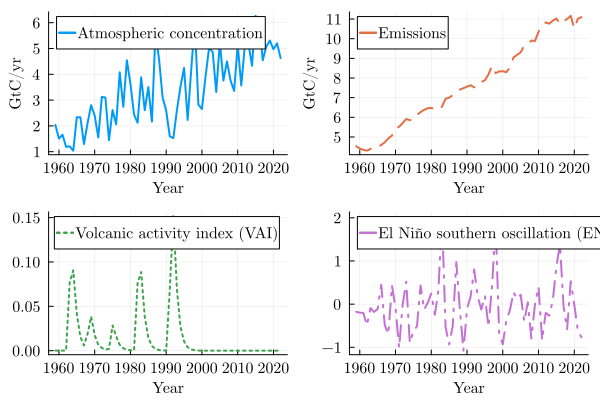

In [3]:
#| label: fig-raw-data
#| fig-cap: Plots of the variables of interest
using Plots

l = @layout [a b; c d]
p1 = plot(year, G, label="Atmospheric concentration", xlabel="Year", ylabel="GtC/yr", title="", style=:solid, linewidth=2, color=1)
p2 = plot(year, E, label="Emissions", xlabel="Year", ylabel="GtC/yr", title="", style=:dash, linewidth=2, color=2)
p3= plot(year, VAI, label="Volcanic activity index (VAI)", xlabel="Year", ylabel="", title="", style=:dot, linewidth=2, color=3)
p4 = plot(year, ENSO, label="El Niño southern oscillation (ENSO)", xlabel="Year", ylabel="", title="", style=:dashdot, linewidth=2, color=4)
all_plot = plot(p1, p2, p3, p4, layout = l, fontfamily="Computer Modern", legendfontsize=10, tickfontsize=10, titlefontfamily="Computer Modern", legendfontfamily="Computer Modern", tickfontfamily="Computer Modern", ylabelfontsize=10, xlabelfontsize=10, titlefontsize=12)

display(all_plot)

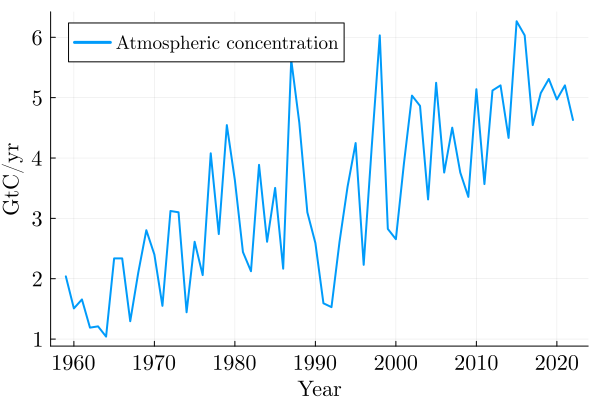

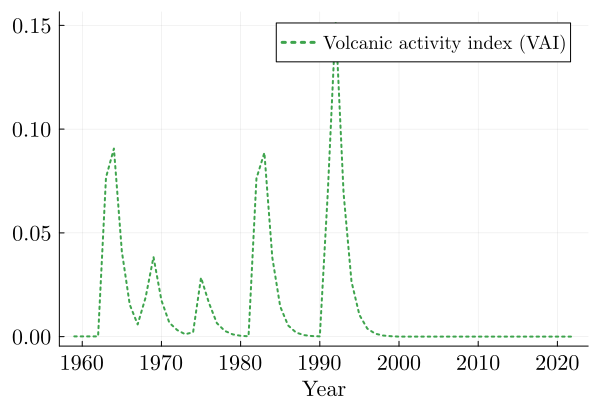

In [4]:
using Plots

p1 = plot(year, G, label="Atmospheric concentration", xlabel="Year", ylabel="GtC/yr", title="", style=:solid, linewidth=2, color=1)
plot!(fontfamily="Computer Modern", legendfontsize=12, tickfontsize=14, titlefontfamily="Computer Modern", legendfontfamily="Computer Modern", tickfontfamily="Computer Modern", ylabelfontsize=14, xlabelfontsize=14, titlefontsize=16)
display(p1)

p3 = plot(year, VAI, label="Volcanic activity index (VAI)", xlabel="Year", ylabel="", title="", style=:dot, linewidth=2, color=3)
plot!(fontfamily="Computer Modern", legendfontsize=12, tickfontsize=14, titlefontfamily="Computer Modern", legendfontfamily="Computer Modern", tickfontfamily="Computer Modern", ylabelfontsize=14, xlabelfontsize=14, titlefontsize=16)
display(p3)

## Linear regression

@bennedsen2024 suggested to estimate the airborne fraction by linear regression. They propose to use the following specification:

$$G_t =  \alpha E_t + \epsilon_t,$$

and estimate $\alpha$, the airborne fraction, using ordinary least squares (OLS). They argue that this approach provides better statistical properties. Among them, the OLS estimator is super-consistent, meaning that it converges to the true value at a faster rate than the classic estimator. They also show that the estimator has lower variance and it is asymptotically normal.

To contrast the results, we first replicate the main results of @bennedsen2024. The authors considered a simple specification of the model, where the emissions variable is the only regressor, and an extended model that includes additional covariates.

### Simple specification of the model

In [5]:
#| echo: true
#| code-fold: false

α₂ = (E'E) \ (E'G)

rss₂ = sum((G - α₂ * E) .^ 2)
σ²₂ = rss₂ / (length(G) - 1)
sd₍α₂₎ = sqrt(σ²₂ / (E'E))

α₂, sd₍α₂₎

(0.44779188441445344, 0.014241317441433234)

### Extended model

Additional covariates, controlling for the El Niño Southern Oscillation (ENSO) and volcanic activity index (VAI). This is the *preferred specification* by @bennedsen2024.

#### Detrending ENSO {#sec-detrend-ENSO}

Note that @bennedsen2024 first detrended the ENSO data using a linear trend. We analyse first if the detrending is necessary.

We plot the ENSO data and the detrended ENSO data.

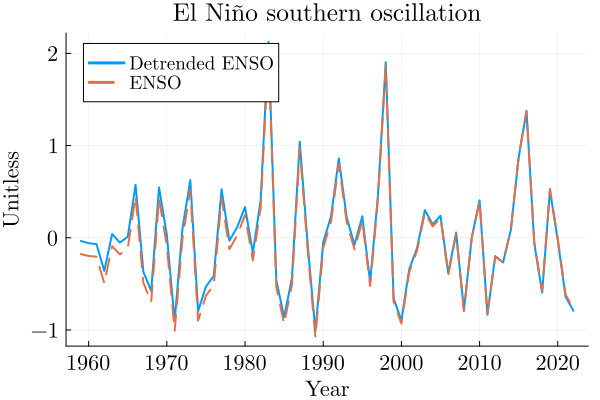

In [6]:
T = length(ENSO)

Xₜ = [ones(T) collect(1:T)]

ρ = (Xₜ'Xₜ) \ (Xₜ'ENSO)

ENSOᵨ = ENSO - Xₜ * ρ    

p5 = plot(year, [ENSOᵨ ENSO], label=["Detrended ENSO" "ENSO"], xlabel="Year", ylabel="Unitless", title="El Niño southern oscillation", linewidth = 2, style = [:solid :dash :dot])
plot!( fontfamily="Computer Modern", legendfontsize=12, tickfontsize=14, titlefontfamily="Computer Modern", legendfontfamily="Computer Modern", tickfontfamily="Computer Modern", ylabelfontsize=14, xlabelfontsize=14, titlefontsize=16, legend = :topleft)
display(p5)

Moreover, we make the hypothesis test of the presence of a linear trend in the ENSO data. The null hypothesis is that there is no linear trend in the data.

In [7]:
using Distributions

resᵨ = ENSO - Xₜ * ρ
σ²ᵨ = sum(resᵨ.^2) / (T - 2)
Var₍ᵨ₎ = σ²ᵨ * inv(Xₜ'Xₜ) 

t1ᵨ = ρ[1] / sqrt( Var₍ᵨ₎[1,1] )
pval1ᵨ = 2 * (1 - cdf(TDist(T-2), abs(t1ᵨ)))

t2ᵨ = ρ[2] / sqrt( Var₍ᵨ₎[2,2] )
pval2ᵨ = 2 * (1 - cdf(TDist(T-2), abs(t2ᵨ)))

[[ρ[1] sqrt(Var₍ᵨ₎[1,1]) t1ᵨ pval1ᵨ]; ρ[2] sqrt(Var₍ᵨ₎[2,2]) t2ᵨ pval2ᵨ]

2×4 Matrix{Float64}:
 -0.144369    0.158836    -0.908919  0.366913
  0.00264145  0.00424887   0.621684  0.536429

Note that the p-values are large, so we fail to reject the null hypothesis. This means that there is no evidence of a linear trend in the ENSO data. Hence, we continue the analysis without detrending the ENSO data.

#### Estimation of the extended model

In [8]:
Xₑ = [E ENSO VAI]
αₑ = (Xₑ'Xₑ) \ (Xₑ'G)

rssₑ = sum((G - Xₑ * αₑ) .^ 2)
σ²ₑ = rssₑ / (length(G) - 3)
var₍αₑ₎ = σ²ₑ * inv(Xₑ'Xₑ)

[ αₑ, sqrt.([var₍αₑ₎[j, j] for j = 1:3]),   αₑ./ sqrt.([var₍αₑ₎[j, j] for j = 1:3]) ]

3-element Vector{Vector{Float64}}:
 [0.4734551237192292, 0.967254219300192, -14.154904191057945]
 [0.010839839871941388, 0.13273608839500087, 2.6969774873983585]
 [43.677317129448944, 7.287047787801323, -5.248432460855461]

In [9]:
tstats = αₑ./ sqrt.([var₍αₑ₎[j, j] for j = 1:3]) 
1- cdf(TDist(T-3), abs(tstats[3]))

1.0227639827276036e-6

Note that the estimate using the ENSO data without detrending is slighly larger than the estimate using the detrended ENSO data. Nonetheless, the difference is small and the estimates are very close.

#### R-squared and adjusted R-squared

We calculate the R-squared and adjusted R-squared for the extended model and compare them with the simple model.

R-squared is not a good measure of goodness-of-fit for nested models given that it never decreases and most likely increases with the number of regressors. The adjusted R-squared corrects this issue by penalizing the inclusion of additional regressors [@davidson2004econometric].

In [10]:
tssₑ = sum(( G .- mean(G)).^2 )

R²₂ = 1 - rss₂ / tssₑ
R²ₑ = 1 - rssₑ / tssₑ


adjR²₂ = 1 - (rss₂ / (T - 1)) / (tssₑ / (T - 1))
adjR²ₑ = 1 - (rssₑ / (T - 3)) / (tssₑ / (T - 1))

R²₂, R²ₑ, adjR²₂, adjR²ₑ

(0.5862507041876346, 0.8012896668141006, 0.5862507041876346, 0.7947745739227596)

The R-squared and adjusted R-squared are higher for the extended model, suggesting that the additional covariates improve the fit of the model.

## Measurement error and bias

Anthropogenic CO$_2$ emissions are given by $E_t = E_t^{FF}+E_t^{LULCC}$, where $E_t^{FF}$ is the emissions from fossil fuels and $E_t^{LULCC}$ is the emissions from land-use and land-cover changes (LULCC). The uncertainty in measurements of the airborne fraction stems in large part from uncertainties in the magnitude of LULCC emissions [@bennedsen2024]. This suggesst that LULCC emissions are subject to measurement error. 

### Plotting LULCCs

@fig-lulcc-measures shows three different measurements of the LULCC variable. The GCP LULCC data are from the Global Carbon Project [@friedlingstein2023global], the H&C LULCC data are from @houghton2022annual, and the vMa LULCC data are from @van2022retracted. 

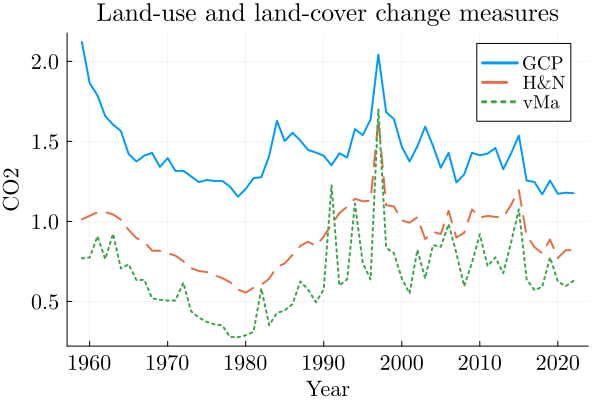

In [11]:
#| label: fig-lulcc-measures
#| fig-cap: Different land-use and land-cover change (LULCC) datasets.
using Plots

lulcc₂ = Vector{Float64}(data[!, 7]);
lulcc₃ = Vector{Float64}(data[!, 8]);

E₂ = fossilfuels .+ lulcc₂;
E₃ = fossilfuels .+ lulcc₃;

plot_lulcc = plot(year, [lulcc lulcc₂ lulcc₃], label=["GCP" "H&N" "vMa"], xlabel="Year", ylabel="CO2", title="Land-use and land-cover change measures", style=[:solid :dash :dot], linewidth=2)
plot!(fontfamily="Computer Modern", legendfontsize=12, tickfontsize=14, titlefontfamily="Computer Modern", legendfontfamily="Computer Modern", tickfontfamily="Computer Modern", ylabelfontsize=14, xlabelfontsize=14, titlefontsize=16, legend=:topright)

display(plot_lulcc)

### Plotting emissions

@fig-emission-measures shows the emissions variable using the different LULCC measurements. The emissions variable is the sum of the fossil fuels and LULCC emissions.

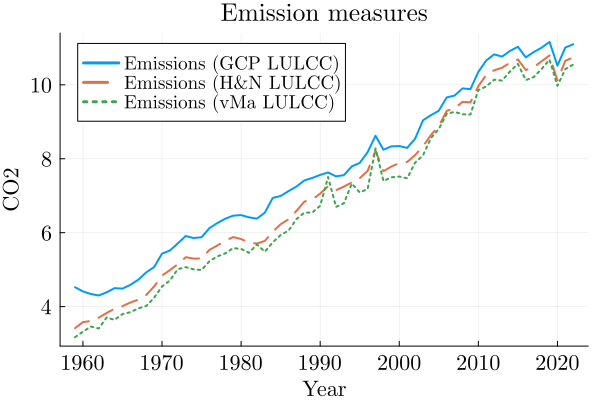

In [12]:
#| label: fig-emission-measures
#| fig-cap: Emission measures using different land use and land cover change (LULCC) datasets.

plot_emisions = plot(year, [E E₂ E₃], label=["Emissions (GCP LULCC)" "Emissions (H&N LULCC)" "Emissions (vMa LULCC)"], xlabel="Year", ylabel="CO2", title="Emission measures", style=[:solid :dash :dot], linewidth=2)
plot!(fontfamily="Computer Modern", legendfontsize=12, tickfontsize=14, titlefontfamily="Computer Modern", legendfontfamily="Computer Modern", tickfontfamily="Computer Modern", ylabelfontsize=14, xlabelfontsize=14, titlefontsize=16, legend=:topleft)

display(plot_emisions)

### Bias due to measurement errors

We show that measurement errors in the emissions variable can bias the estimates of the airborne fraction. Assume that we do not observe the true emissions but a noisy version of it. That is, we observe $E_t = E_t^* + \eta_t$, where $E_t^*$ is the true emissions and $\eta_t$ is the measurement error, which we assume has mean zero and variance $\sigma^2_\eta$. Estimating the airborne fraction using the noisy emissions by OLS:

$$\hat{\alpha}_{ME} = \frac{\sum_{t=1}^T E_t G_t}{\sum_{t=1}^T E_t^2} = \frac{\sum_{t=1}^T (E_t^*G_t + \eta_t G_t)}{\sum_{t=1}^T (E_t^{*2}+2E_t^*\eta_t+\eta_t^2)}\rightarrow \frac{\frac{1}{T}\sum_{t=1}^T E_t^*G_t}{\frac{1}{T}\sum_{t=1}^T E_t^{*2}+\sigma_\eta^2},$$

which shows that the OLS estimator is biased downwards. The bias increases with the variance of the measurement error, which is unknown. 

To correct the bias, we can estimate the airborne fraction using instrumental variables. Unlike Deming regression, instrumental variables do not require the variance of the measurement error to be known, nor assuming that they are normally distributed.

## Instrumental variables

To use instrumental variables, we need a variable that is correlated with the emissions but uncorrelated with the measurement error. This variable is called an instrument.

There are several measurements of the land-use and land-coverage changes (LULCC) variable [@fig-lulcc-measures], which forms part of the emissions measurement [@fig-emission-measures]. Even under the assumption that all of these different measurements are subject to measurement error, we can use them as instruments to correct the bias in the estimate of the airborne fraction. 

Consider a second emissions measurement, $E_{2,t} = E_t^* + \omega_t$, where $\omega_t$ is the measurement error in the second emissions measurement. We assume that $\omega_t$ is independent of $\eta_t$ since the two measurements are performed independently. We can use the second emissions measurement as an instrument to estimate the airborne fraction. The instrument is correlated with the emissions variable given that they share the same true emissions; but, by construction, uncorrelated with the measurement error in the emissions variable.

Consider the following estimator for the airborne fraction:

$$
\hat{\alpha}_{IV} = \frac{\sum_{t=1}^T E_{2,t} G_t}{\sum_{t=1}^T E_{2,t}E_{t}} = \frac{\sum_{t=1}^T (E_t^*G_t + \omega_t G_t)}{\sum_{t=1}^T (E_t^{*2}+E_t^*\eta_t+E_t^*\omega_t+\eta_t\omega_t)} \rightarrow \frac{\frac{1}{T}\sum_{t=1}^T E_t^*G_t}{\frac{1}{T}\sum_{t=1}^T E_t^{*2}} = \hat{\alpha},
$$ {#eq-iv-estimator}

where $\hat{\alpha}$ is the estimator without measurement errors. Hence, @eq-iv-estimator shows that the instrumental variables estimator is unbiased. Moreover, the estimator is consistent and asymptotically normal, regardless of the distribution of the measurement errors. 

Note that the theoretical properties of the instrumental variables estimator are a direct consequence of the additive nature of the measurement errors. The order of probability of the measurement errors and the variables multiplied by them is lower than the order of the variables themselves. For a textbook treatment on orders of probability, see @Hamilton1994.

Depending on which variable is selected as the single instrument, two different estimators can be obtained. Later, we will extend the analysis to include both instruments simultaneously.

In [13]:
#| echo: true
# H&N LULCC
α₍ₕₙ₎ = (E₂'E) \ (E₂'G)

# vMa LULCC
α₍ᵥₘₐ₎ = (E₃'E) \ (E₃'G)

α₍ₕₙ₎, α₍ᵥₘₐ₎

(0.4478895029464986, 0.44815234697503475)

In contrast to the Deming regression, there is a closed-form expression to compute the standard error of the instrumental variables estimator. 

It is given by:

$$
\widehat{\text{Var}}(\hat{\alpha}_{IV}) = \hat{\sigma}^2_{iv} \left(\sum_{t=1}^T E_{2,t} E_t\right) \left(\sum_{t=1}^T E_{2,t} E_{2,t}\right)^{-1} \left(\sum_{t=1}^T E_{2,t} E_t\right),
$$ {#eq-iv-variance}

where $\hat{\sigma}^2_{IV} = \frac{1}{T-1}\sum_{t=1^T}(G_t-\hat{\alpha}_{IV}E_t)^2$ is the estimator of the variance of the residuals.

In [14]:
# H&N LULCC
rss₍ₕₙ₎ = sum((G - α₍ₕₙ₎ * E) .^ 2)
σ²₍ₕₙ₎ = rss₍ₕₙ₎ / (length(G) - 1)
sd₍α₍ₕₙ₎₎ = sqrt(σ²₍ₕₙ₎ / (E₂'E) * (E₂'E₂) / (E'E₂))

# vMa LULCC
rss₍ᵥₘₐ₎ = sum((G - α₍ᵥₘₐ₎ * E) .^ 2)
σ²₍ᵥₘₐ₎ = rss₍ᵥₘₐ₎ / (length(G) - 1)
sd₍α₍ᵥₘₐ₎₎ = sqrt(σ²₍ᵥₘₐ₎ / (E₃'E) * (E₃'E₃) / (E'E₃))

sd₍α₍ₕₙ₎₎, sd₍α₍ᵥₘₐ₎₎

(0.014250528339527469, 0.014259657933478448)

Estimates and standard errors.

In [15]:
[α₍ₕₙ₎ α₍ᵥₘₐ₎; sd₍α₍ₕₙ₎₎ sd₍α₍ᵥₘₐ₎₎]

2×2 Matrix{Float64}:
 0.44789    0.448152
 0.0142505  0.0142597

## Generalised instrumental variables

Instrumental variables can be extended to simultaneously use more than one instrument for each variable with measurement error. The estimator is denoted as the generalised instrumental variables (GIV) and it is given by:

$$\hat{\alpha}_{GIV} = (\tilde{E}'\tilde{E})^{-1}\tilde{E}' G,$$

where $\tilde{E}_t$ is the fitted value from the following regression:

$$E_t = \beta_1 E_{2,t} + \beta_2 E_{3,t} + \epsilon_t,$$

where $E_{2,t} = E_t^* + \omega_t$ and $E_{3,t} = E_t^* + \zeta_t$ are the second and third emissions measurements, respectively. The coefficients $\beta_1$ and $\beta_2$ are estimated by linear regression.

Moreover, the variance of the GIV estimator is given by:

$$\widehat{\text{Var}}(\hat{\alpha}_{GIV}) = \hat{\sigma}^2_{GIV} (\tilde{E}'\tilde{E})^{-1},$$

where $\hat{\sigma}^2_{GIV} = \frac{1}{T-1}\sum_{t=1}^T(G_t-\hat{\alpha}_{GIV}E_t)^2$ is the estimator of the variance of the residuals.

In [16]:
X = E
W = [E₂ E₃]
PW = W * ((W' * W) \ W')

αᵢ = (X' * PW * X) \ (X' * PW * G)

rssᵢ = sum((G - X * αᵢ) .^ 2)
σ²ᵢ = rssᵢ / (length(G) - 1)
var₍αᵢ₎ = σ²ᵢ * inv(X' * PW * X)
sd₍αᵢ₎ = sqrt(var₍αᵢ₎)

αᵢ, sd₍αᵢ₎

(0.44763765543651457, 0.014247682195423763)

### Tests for IV

Having more than one instrument further allows us to test the validity of the instruments. Two common tests for GIV are Sargan's instrument validity test and the Hausman's overidentification test.

#### Sargan test

Sargan's test is a test to determine if the instruments are correlated with the endogenous variable. 

In [17]:
using Statistics
γ = (W' * W) \ (W' * X)
rssₐ = sum((X - W * γ) .^ 2)

R²ᵢ = 1 - rssₐ / (sum((X .- mean(X)) .^ 2))

ȷ = length(X) * R²ᵢ

63.236926118485016

In [18]:
using Distributions
1 - cdf(Chisq(1), ȷ)

1.887379141862766e-15

#### Hausman test

Hausman's test is a test to determine if there is a systematic difference between the instrumental variables and the OLS estimates.

In [19]:
Hᵢ = (αᵢ - α₂)' * ((sd₍αᵢ₎^2 - sd₍α₂₎^2) \ (αᵢ - α₂))
H₍ₕₙ₎ = (α₍ₕₙ₎ - α₂)' * ((sd₍α₍ₕₙ₎₎^2 - sd₍α₂₎^2) \ (α₍ₕₙ₎ - α₂))
H₍ᵥₘₐ₎ = (α₍ᵥₘₐ₎ - α₂)' * ((sd₍α₍ᵥₘₐ₎₎^2 - sd₍α₂₎^2) \ (α₍ᵥₘₐ₎ - α₂)) 

[1 - cdf(Chisq(1), Hᵢ) 1 - cdf(Chisq(1), H₍ₕₙ₎) 1 - cdf(Chisq(1), H₍ᵥₘₐ₎)]


1×3 Matrix{Float64}:
 0.71721  0.848874  0.618083

## Extended model

We consider adding additional covariates to the model. In particular, we consider adding $ENSO$ (El Niño Southern Oscillation) and $VAI$ (volcanic activity index) as covariates. These variables are known to affect the carbon cycle and can potentially influence the airborne fraction. Note that these variables were not considered in the Deming regression analysis by @bennedsen2024.

We estimate the following model:

$$G_t = \alpha E_t + \gamma_1 ENSO_t + \gamma_2 VAI_t + \epsilon_t,$$

where $ENSO_t$ and $VAI_t$ are the El Niño Southern Oscillation and volcanic activity index at time $t$, respectively.

Estimating the extended model using instrumental variables is straightforward. We can include the additional covariates in the regression and instrument the emissions variable. 

Standard errors for the extended model using instrumental variables are also straightforward.

In [20]:
Xₑ = [E ENSO VAI]

# H&N LULCC with ENSO and VAI
Wₕₙ = [E₂ ENSO VAI]
PWₕₙ = Wₕₙ * ((Wₕₙ' * Wₕₙ) \ Wₕₙ')

α₍ₕₙₑ₎ = (Xₑ' * PWₕₙ * Xₑ) \ (Xₑ' * PWₕₙ * G)
rss₍ₕₙₑ₎ = sum((G - Xₑ * α₍ₕₙₑ₎) .^ 2)
σ²₍ₕₙₑ₎ = rss₍ₕₙₑ₎ / (length(G) - 3)
var₍α₍ₕₙₑ₎₎ = σ²₍ₕₙₑ₎ * inv(Xₑ'PWₕₙ * Xₑ)
sd₍α₍ₕₙₑ₎₎ = sqrt.([var₍α₍ₕₙₑ₎₎[j, j] for j = 1:3])

# vMa LULCC with ENSO and VAI
Wᵥₘₐ = [E₃ ENSO VAI]
PWᵥₘₐ = Wᵥₘₐ * ((Wᵥₘₐ' * Wᵥₘₐ) \ Wᵥₘₐ')

α₍ᵥₘₐₑ₎ = (Xₑ' * PWᵥₘₐ * Xₑ) \ (Xₑ' * PWᵥₘₐ * G)
rss₍ᵥₘₐₑ₎ = sum((G - Xₑ * α₍ᵥₘₐₑ₎) .^ 2)
σ²₍ᵥₘₐₑ₎ = rss₍ᵥₘₐₑ₎ / (length(G) - 3)
var₍α₍ᵥₘₐₑ₎₎ = σ²₍ᵥₘₐₑ₎ * inv(Xₑ'PWᵥₘₐ * Xₑ)
sd₍α₍ᵥₘₐₑ₎₎ = sqrt.([var₍α₍ᵥₘₐₑ₎₎[j, j] for j = 1:3])

# GIV with ENSO and VAI
Wₑ = [E₂ E₃ ENSO VAI]
PWₑ = Wₑ * ((Wₑ' * Wₑ) \ Wₑ')

α₍ᵢₑ₎ = (Xₑ' * PWₑ * Xₑ) \ (Xₑ' * PWₑ * G)
res₍ᵢₑ₎ = G - Xₑ * α₍ᵢₑ₎
σ²₍ᵢₑ₎ = sum(res₍ᵢₑ₎ .^ 2) / (length(G) - 4)
var₍α₍ᵢₑ₎₎ = σ²₍ᵢₑ₎ * inv(Xₑ' * PWₑ * Xₑ)
sd₍α₍ᵢₑ₎₎ = sqrt.([var₍α₍ᵢₑ₎₎[j, j] for j = 1:3])

[α₍ₕₙₑ₎ α₍ᵥₘₐₑ₎ α₍ᵢₑ₎; sd₍α₍ₕₙₑ₎₎ sd₍α₍ᵥₘₐₑ₎₎ sd₍α₍ᵢₑ₎₎]

6×3 Matrix{Float64}:
   0.472673     0.472328     0.472978
   0.96578      0.965129     0.966355
 -14.0822     -14.0501     -14.1106
   0.0108476    0.0108547    0.0109354
   0.132744     0.132752     0.133841
   2.69734      2.6977       2.71959

#### Instruments Tests {#sec-instruments-tests}

Sargan and Hausman tests for the extended model.

In [21]:
γₑ = (Wₑ' * Wₑ) \ (Wₑ' * Xₑ)
rss₍ᵢₑ₎ = sum((Xₑ - Wₑ * γₑ) .^ 2)

R²₍ᵢₑ₎ = 1 - rss₍ᵢₑ₎ / (sum((Xₑ .- mean(Xₑ)) .^ 2))

ȷₑ = length(X) * R²₍ᵢₑ₎

1 - cdf(Chisq(3), ȷₑ)

8.526512829121202e-14

In [22]:
Hₑ = (α₍ᵢₑ₎ - αₑ)' * ((var₍α₍ᵢₑ₎₎ - var₍αₑ₎ ) \ (α₍ᵢₑ₎ - αₑ))
H₍ₕₙₑ₎ = (α₍ₕₙₑ₎ - αₑ)' * ((var₍α₍ₕₙₑ₎₎ - var₍αₑ₎ ) \ (α₍ₕₙₑ₎ - αₑ))
H₍ᵥₘₐₑ₎ = (α₍ᵥₘₐₑ₎ - αₑ)' * ((var₍α₍ᵥₘₐₑ₎₎ - var₍αₑ₎) \ (α₍ᵥₘₐₑ₎ - αₑ))

[1 - cdf(Chisq(3), Hₑ) 1 - cdf(Chisq(3), H₍ₕₙₑ₎) 1 - cdf(Chisq(3), H₍ᵥₘₐₑ₎)]    

1×3 Matrix{Float64}:
 0.990682  0.301239  0.267212

## Recent subsample {#sec-recent-subsample}

Given the variability of the LULCC measurements at the beginning of the series, we consider a recent subsample of the data. We consider the data from 1992 and estimate the airborne fraction using the new approach.

Getting subsample data.

In [23]:
E92 = E[year.>=1992];
G92 = G[year.>=1992];
E92₂ = E₂[year.>=1992];
E92₃ = E₃[year.>=1992];
VAI92 = VAI[year.>=1992];
ENSO92 = ENSO[year.>=1992];

New approach for the recent subsample.

In [24]:
α92₂ = (E92'E92₂) \ (E92₂'G92)

rss92₂ = sum((G92 - α92₂ * E92₂) .^ 2)
σ²92₂ = rss92₂ / (length(G92) - 1)
sd₍α92₂₎ = sqrt(σ²92₂ / (E92₂'E92₂))

α92₂, sd₍α92₂₎

(0.4496265998122475, 0.01847550703053799)

Instrumental variables for the recent subsample.

In [25]:
X92 = E92
W92 = [E92₂ E92₃]
PW92 = W92 * ((W92' * W92) \ W92')

# H&N LULCC
α92₍ₕₙ₎ = (E92₂'E92) \ (E92₂'G92)
rss92₍ₕₙ₎ = sum((G92 - α92₍ₕₙ₎ * E92) .^ 2)
σ²92₍ₕₙ₎ = rss92₍ₕₙ₎ / (length(G92) - 1)
sd₍α92₍ₕₙ₎₎ = sqrt(σ²92₍ₕₙ₎ / (E92₂'E92) * (E92₂'E92₂) / (E92'E92₂))

# vMa LULCC
α92₍ᵥₘₐ₎ = (E92₃'E92) \ (E92₃'G92)
rss92₍ᵥₘₐ₎ = sum((G92 - α92₍ᵥₘₐ₎ * E92) .^ 2)
σ²92₍ᵥₘₐ₎ = rss₍ᵥₘₐ₎ / (length(G92) - 1)
sd₍α92₍ᵥₘₐ₎₎ = sqrt(σ²92₍ᵥₘₐ₎ / (E92₃'E92) * (E92₃'E92₃) / (E92'E92₃))

# GIV
α92ᵢ = (X92' * PW92 * X92) \ (X92' * PW92 * G92)
rss92ᵢ = sum((G92 - X92 * α92ᵢ) .^ 2)
σ²92ᵢ = rss92ᵢ / (length(G92) - 1)
sd₍α92ᵢ₎ = sqrt(σ²92ᵢ * inv(X92' * PW92 * X92))

[α92₍ₕₙ₎ α92₍ᵥₘₐ₎ α92ᵢ; sd₍α92₍ₕₙ₎₎ sd₍α92₍ᵥₘₐ₎₎ sd₍α92ᵢ₎]

2×3 Matrix{Float64}:
 0.449627   0.450219   0.449493
 0.0173104  0.0244938  0.0173103

Extended model for the recent subsample.

In [26]:
X92ₑ = [E92 ENSO92 VAI92]

α92ₑ = (X92ₑ'X92ₑ) \ (X92ₑ'G92)
rss92ₑ = sum((G92 - X92ₑ * α92ₑ) .^ 2)
σ²92ₑ = rss92ₑ / (length(G92) - 3)
var₍α92ₑ₎ = σ²92ₑ * inv(X92ₑ'X92ₑ)

[ α92ₑ, sqrt.([var₍α92ₑ₎[j, j] for j = 1:3]) ]

2-element Vector{Vector{Float64}}:
 [0.4622219656227806, 1.0237798088559882, -17.167003554558086]
 [0.011245930036851546, 0.17229498857880865, 3.660364706338823]

Instrumental variables for the recent subsample and extended model.

In [27]:
X92ₑ = [E92 ENSO92 VAI92]

# H&N LULCC
W92₍ₕₙₑ₎ = [E92₂ ENSO92 VAI92]
PW92₍ₕₙₑ₎ = W92₍ₕₙₑ₎ * ((W92₍ₕₙₑ₎' * W92₍ₕₙₑ₎) \ W92₍ₕₙₑ₎')

α92₍ₕₙₑ₎ = (X92ₑ' * PW92₍ₕₙₑ₎ * X92ₑ) \ (X92ₑ' * PW92₍ₕₙₑ₎ * G92)
rss92₍ₕₙₑ₎ = sum((G92 - X92ₑ * α92₍ₕₙₑ₎) .^ 2)
σ²92₍ₕₙₑ₎ = rss92₍ₕₙₑ₎ / (length(G92) - 3)
var₍α92₍ₕₙₑ₎₎ = σ²92₍ₕₙₑ₎ * inv(X92ₑ' * PW92₍ₕₙₑ₎ * X92ₑ)
sd₍α92₍ₕₙₑ₎₎ = sqrt.([var₍α92₍ₕₙₑ₎₎[j, j] for j = 1:3])

# vMa LULCC
W92₍ᵥₘₐₑ₎ = [E92₃ ENSO92 VAI92]
PW92₍ᵥₘₐₑ₎ = W92₍ᵥₘₐₑ₎ * ((W92₍ᵥₘₐₑ₎' * W92₍ᵥₘₐₑ₎) \ W92₍ᵥₘₐₑ₎')

α92₍ᵥₘₐₑ₎ = (X92ₑ' * PW92₍ᵥₘₐₑ₎ * X92ₑ) \ (X92ₑ' * PW92₍ᵥₘₐₑ₎ * G92)
rss92₍ᵥₘₐₑ₎ = sum((G92 - X92ₑ * α92₍ᵥₘₐₑ₎) .^ 2)
σ²92₍ᵥₘₐₑ₎ = rss92₍ᵥₘₐₑ₎ / (length(G92) - 3)
var₍α92₍ᵥₘₐₑ₎₎ = σ²92₍ᵥₘₐₑ₎ * inv(X92ₑ' * PW92₍ᵥₘₐₑ₎ * X92ₑ)
sd₍α92₍ᵥₘₐₑ₎₎ = sqrt.([var₍α92₍ᵥₘₐₑ₎₎[j, j] for j = 1:3])

# GIV
W92ₑ = [E92₂ E92₃ ENSO92 VAI92]
PW92ₑ = W92ₑ * ((W92ₑ' * W92ₑ) \ W92ₑ')

α92₍ᵢₑ₎ = (X92ₑ' * PW92ₑ * X92ₑ) \ (X92ₑ' * PW92ₑ * G92)
rss92₍ᵢₑ₎ = sum((G92 - X92ₑ * α92₍ᵢₑ₎) .^ 2)
σ²92₍ᵢₑ₎ = rss92₍ᵢₑ₎ / (length(G92) - 3)
var92₍α₍ᵢₑ₎₎ = σ²92₍ᵢₑ₎ * inv(X92ₑ' * PW92ₑ * X92ₑ)
sd₍α92₍ᵢₑ₎₎ = sqrt.([var92₍α₍ᵢₑ₎₎[j, j] for j = 1:3])

# All results
[α92₍ₕₙₑ₎ sd₍α92₍ₕₙₑ₎₎; α92₍ᵥₘₐₑ₎ sd₍α92₍ᵥₘₐₑ₎₎; α92₍ᵢₑ₎ sd₍α92₍ᵢₑ₎₎]

9×2 Matrix{Float64}:
   0.462196  0.0112469
   1.02376   0.172295
 -17.1651    3.66038
   0.462269  0.0112487
   1.02382   0.172295
 -17.1705    3.66041
   0.462177  0.0112468
   1.02374   0.172295
 -17.1637    3.66038

### Alternative datasets

Similar to @bennedsen2024, we consider the specifications of the model using the H&N and vMa LULCC measurements. We estimate the airborne fraction using the new approach and instrumental variables.

#### H&N LULCC

Specifying the model using the H&N LULCC measurements and using GCP LULCC and vMA LULCC as instruments.

In [28]:
α_hn_gcp = (E'E₂) \ (E'G)
rss_hn_gcp = sum((G - α_hn_gcp * E₂) .^ 2)
σ²_hn_gcp = rss_hn_gcp / (length(G) - 1)
sd₍α_hn_gcp₎ = sqrt(σ²_hn_gcp * (E'E₂) / (E'E) * (E'E₂))

α_hn_vma = (E₃'E₂) \ (E₃'G)
rss_hn_vma = sum((G - α_hn_vma * E₂) .^ 2)
σ²_hn_vma = rss_hn_vma / (length(G) - 1)
sd₍α_hn_vma₎ = sqrt(σ²_hn_vma * (E₃'E₂) / (E₃'E₃) * (E₃'E₂))

[α_hn_gcp α_hn_vma; sd₍α_hn_gcp₎ sd₍α_hn_vma₎]

2×2 Matrix{Float64}:
  0.47605   0.475619
 54.9119   54.9349

#### vMa LULCC

Specifying the model using the vMa LULCC measurements and using GCP LULCC and H&N LULCC as instruments.

In [29]:
α_vma_gcp = (E'E₃) \ (E'G)
rss_vma_gcp = sum((G - α_vma_gcp * E₃) .^ 2)
σ²_vma_gcp = rss_vma_gcp / (length(G) - 1)
sd₍α_vma_gcp₎ = sqrt(σ²_vma_gcp * (E'E₃) / (E'E) * (E'E₃))

α_vma_hn = (E₂'E₃) \ (E₂'G)
rss_vma_hn = sum((G - α_vma_hn * E₃) .^ 2)
σ²_vma_hn = rss_vma_hn / (length(G) - 1)
sd₍α_vma_hn₎ = sqrt(σ²_vma_hn * (E₂'E₃) / (E₂'E₂) * (E₂'E₃))

[α_vma_gcp α_vma_hn; sd₍α_vma_gcp₎ sd₍α_vma_hn₎]

2×2 Matrix{Float64}:
  0.491074   0.490342
 53.2731    53.3285

## Deming with FWL theorem

The theoretical development of the Deming regression based on the [Frisch-Waugh-Lovell](supplementary.ipynb#sec-fwl) theorem is presented in [Theorem 1](supplementary.ipynb#thm-multivariate-Deming) in the [supplementary material](supplementary.ipynb#sec-deming-regression-covariates). The theorem states that the OLS estimator of the airborne fraction in the preferred specification can be obtained by regressing the residuals of the emissions variable from the covariates on the residuals of the airborne fraction from the covariates.

First, we use the Frisch-Waugh-Lovell theorem in the preferred specification of the model by @bennedsen2024.

In [30]:
AX = [ENSO VAI]
coefs1 = (AX'AX) \ (AX'G)
resₐ = G - AX * coefs1

coefs2 = (AX'AX) \ (AX'E)
resₑ = E - AX * coefs2

α₋ = (resₑ'resₑ) \ (resₑ'resₐ)

0.4734551237192293

Above, we also compute the airbone fraction in the preferred specification of the model to show that it is identical to the OLS estimator.

### Deming regression standard errors {#sec-deming-se}

There is no closed-form expression to compute the standard errors of the Deming regression. Hence, we propose to use the bootstrap method to estimate the standard errors and confidence intervals.

First proposed by @efron1992bootstrap, bootstrap has become a major tool for approximating sampling distributions and variance of complex statistics. This is perhaps not surprising in  view of its ability to estimate distributions for statistics even when analytical solutions are unavailable. In addition, bootstrap methods often yield more accurate results than standard methods. Similarly, in the context of  confidence intervals, bootstrap has been often employed as a means for improving upon the accuracy of standard intervals [@diciccio1996bootstrap]. 

We show how to employ a form of model-based bootstrap approach to calculate the confidence intervals of the Deming regression esstimate $\hat{\alpha}_{Deming}$ in the simple specification. The algorithm proceeds as follows:

1. Estimate the equation $G_{t}=\alpha E+u_{t}$ using Deming regression to obtain $\hat{\alpha}_{Deming}$ and recover the residuals $\hat{u}_{t}$ for $t=1,\dots, T$ based on $\hat{\alpha}_{Deming}$. Let $\tilde{u}_{t}=\hat{u}_{t}-\frac{1}{T}\sum_{t=1}^{T}\hat{u}_{t}$ be the recentered residuals.
2. Sample randomly (with replacement) the residuals $\tilde{u}_{t}$ to create the bootstrap pseudo-residuals $\tilde{u}^{\ast}_{t}$. Create pseudo-data in the $G$ domain by using recursively the following equation:
$$
G^{\ast}_{t}=\hat{\alpha}_{Deming} E_{t}+\tilde{u}^{\ast}_{t}.
$$ {#eq-dem-boot}
3. Repeat the previous step B times(with B sufficiently large), and generate independent copies $\hat{\alpha}^{\ast}_{Deming,1}\dots,\hat{\alpha}^{\ast}_{Deming,B}$ based on @eq-dem-boot. 
4. Calculate $s.e(\hat{\alpha}_{Deming})=\sqrt{\frac{1}{B-1}\sum_{i=1}^{B}(\hat{\alpha}^{\ast}_{Deming,i}-\bar{\hat{\alpha}}^{\ast}_{Deming})^2}$ where $\bar{\hat{\alpha}}^{\ast}_{Deming}=\frac{1}{B}\sum_{i=1}^{B}\hat{\alpha}^{\ast}_{Deming,i}$. 
5. The confidence intervals are then obtained as: 
$$
\left[\hat{\alpha}_{Deming}- q^{\ast}(1-\mathit{\alpha}/2)\ s.e(\hat{\alpha}_{Deming}),\hat{\alpha}_{Deming}+ q^{\ast}(\mathit{\alpha}/2)\ s.e(\hat{\alpha}_{Deming})\right],
$$ 
where $q^{\ast}(1-\mathit{\alpha}/2)$ and $q^{\ast}(\mathit{\alpha}/2)$ denote the $1-\mathit{\alpha}/2$ and $\mathit{\alpha}/2$ percentiles of $\hat{\alpha}^{\ast}_{Deming}$. 

The bootstrap procedure does not assume a Normal distribution and minimises computation error compared to the jackknife.


We write a function to compute the Deming regression standard errors.

In [31]:
#| code-fold: true
function Deming_se_ConfI(y::Array{Float64}, x::Array{Float64}, δ::Float64, B::Int64, a::Float64)
    ######################################################################
    # Function Arguments
    # y,x: dependent and independent variables
    # δ: ratio between the measurement error variances assumed known
    # B: number of bootstrap replications e.g. 9999
    # a: significance level chosen by the researcher e.g. 0.05
    # Note: Work in progress shows that bootstrapping can also be used to correct the coefficient  
    # for small sample bias. Not pursued here.
    ######################################################################
    T = length(y)
    y_boot = zeros(T, 1)
    alpha_boot = zeros(B, 1)
    alpha_boot = vec(zeros(B, 1))
    M₍xx₎ = x'x
    M₍xy₎ = x'y
    M₍yy₎ = y'y
    alpha_dem = (M₍yy₎ - δ * M₍xx₎ + sqrt((M₍yy₎ - δ * M₍xx₎)^2 + 4 * δ * M₍xy₎^2)) / (2 * M₍xy₎)
    resid = y - alpha_dem * x
    resid = resid .- mean(resid) #recenter residuals
    #Bootstrap
    for i = 1:B
        y_boot = alpha_dem * x + sample(resid, T, replace=true)
        M₍xx₎_boot = x'x
        M₍xy₎_boot = x'y_boot
        M₍yy₎_boot = y_boot'y_boot
        alpha_boot[i] = (M₍yy₎_boot - δ * M₍xx₎_boot + sqrt((M₍yy₎_boot - δ * M₍xx₎_boot)^2 + 4 * δ * M₍xy₎_boot^2)) / (2 * M₍xy₎_boot)
    end
    se = sqrt(sum((alpha_boot .- mean(alpha_boot)) .^ 2) / (B - 1)) # Calculate standard errors
    lower = quantile(alpha_boot, 1 - a / 2)
    upper = quantile(alpha_boot, a / 2)
    return alpha_dem, se, alpha_dem - lower * se, alpha_dem + upper * se
end

Deming_se_ConfI (generic function with 1 method)

We use the function to compute the estimates, standard errors, and confidence intervals of the airborne fraction in the preferred specification of the model. We do this by calling the function on the residuals of the emissions variable from the covariates and the residuals of the airborne fraction from the covariates.

We use 9,999 bootstrap replications to estimate the standard errors and confidence intervals.

In [32]:
δₑ = zeros(5, 5)
δₑ[1, :] = [0.2 0.5 1 2 5]

for ii = 1:5
    thisdelta = Deming_se_ConfI(resₐ, resₑ, δₑ[1, ii], 9999, 0.05)
    δₑ[2, ii] = thisdelta[1]
    δₑ[3, ii] = thisdelta[2]
    δₑ[4, ii] = thisdelta[3]
    δₑ[5, ii] = thisdelta[4]
end

display(δₑ)

5×5 Matrix{Float64}:
 0.2        0.5       1.0        2.0        5.0
 0.481519   0.478173  0.476241   0.474985   0.474106
 0.0106537  0.010605  0.0107897  0.0105972  0.0105209
 0.476078   0.472833  0.470844   0.469716   0.468893
 0.486511   0.483075  0.481179   0.479816   0.478882

### Deming regression in the simple specification

For completeness, we also compute the Deming regression in the simple specification of the model. The standard errors and confidence intervals were not computed in the paper by @bennedsen2024.

In [33]:
δₛ = zeros(5, 5)
δₛ[1, :] = [0.2 0.5 1 2 5]

for ii = 1:5
    thisdelta = Deming_se_ConfI(G, E, δₑ[1, ii], 9999, 0.05)
    δₛ[2, ii] = thisdelta[1]
    δₛ[3, ii] = thisdelta[2]
    δₛ[4, ii] = thisdelta[3]
    δₛ[5, ii] = thisdelta[4]
end

display(δₛ)

5×5 Matrix{Float64}:
 0.2        0.5        1.0        2.0        5.0
 0.462305   0.456067   0.4526     0.450406   0.448895
 0.0150779  0.0146689  0.0145756  0.0142762  0.0140945
 0.454668   0.448839   0.445511   0.44353    0.442156
 0.469048   0.462452   0.458859   0.456483   0.45485

## Deming regression in the recent subsample

### Simple specification

In [34]:
δ₉₂ = zeros(5, 5)
δ₉₂[1, :] = [0.2 0.5 1 2 5]

for ii = 1:5
    thisdelta = Deming_se_ConfI(G92, E92, δ₉₂[1, ii], 9999, 0.05)
    δ₉₂[2, ii] = thisdelta[1]
    δ₉₂[3, ii] = thisdelta[2]
    δ₉₂[4, ii] = thisdelta[3]
    δ₉₂[5, ii] = thisdelta[4]
end

display(δ₉₂)

5×5 Matrix{Float64}:
 0.2        0.5        1.0        2.0        5.0
 0.459831   0.455479   0.453053   0.451512   0.450449
 0.0175501  0.0175402  0.0171309  0.0172367  0.01725
 0.450973   0.446791   0.444655   0.443108   0.442078
 0.467478   0.462965   0.460299   0.45875    0.457651

### Extended model

FWL theorem in the extended model and recent subsample.

In [35]:
AX92 = [ENSO92 VAI92]
coefs921 = (AX92'AX92) \ (AX92'G92)
res92ₐ = G92 - AX92 * coefs921

coefs922 = (AX92'AX92) \ (AX92'E92)
res92ₑ = E92 - AX92 * coefs922;

Deming regression standard errors in the extended model and recent subsample.

In [36]:
δ₉₂ₑ = zeros(5, 5)
δ₉₂ₑ[1, :] = [0.2 0.5 1 2 5]

for ii = 1:5
    thisdelta = Deming_se_ConfI(res92ₐ, res92ₑ, δ₉₂ₑ[1, ii], 9999, 0.05)
    δ₉₂ₑ[2, ii] = thisdelta[1]
    δ₉₂ₑ[3, ii] = thisdelta[2]
    δ₉₂ₑ[4, ii] = thisdelta[3]
    δ₉₂ₑ[5, ii] = thisdelta[4]
end

display(δ₉₂ₑ)

5×5 Matrix{Float64}:
 0.2        0.5        1.0        2.0        5.0
 0.466195   0.464524   0.463574   0.462962   0.462536
 0.0105979  0.0105614  0.0105426  0.0108638  0.0106316
 0.460995   0.459377   0.458459   0.457696   0.457402
 0.470956   0.469227   0.468254   0.467765   0.467229

## Summary of results

The table below shows the estimates of the airborne fraction using the different methods. The table includes the estimates, standard errors, and confidence intervals. 

### Table of results

In [37]:
#| code-fold: true

results_analysis = DataFrame("Model" => String[], "Estimate" => Float64[], "Std. Error" => Float64[], "Confidence Int." => Vector{Float64}[])

nd = 4;

push!(results_analysis, ["IV Regression (H&N LULCC)", α₍ₕₙ₎, sd₍α₍ₕₙ₎₎, round.([α₍ₕₙ₎ - 1.96 * sd₍α₍ₕₙ₎₎, α₍ₕₙ₎ + 1.96 * sd₍α₍ₕₙ₎₎], digits=nd)])
push!(results_analysis, ["IV Regression (vMA LULCC)", α₍ᵥₘₐ₎, sd₍α₍ᵥₘₐ₎₎, round.([α₍ᵥₘₐ₎ - 1.96 * sd₍α₍ᵥₘₐ₎₎, α₍ᵥₘₐ₎ + 1.96 * sd₍α₍ᵥₘₐ₎₎], digits=nd)])
push!(results_analysis, ["GIV Regression", αᵢ, sd₍αᵢ₎, round.([αᵢ - 1.96 * sd₍αᵢ₎, αᵢ + 1.96 * sd₍αᵢ₎], digits=nd)])
push!(results_analysis, ["IV Regression (H&N LULCC) with ENSO and VAI", α₍ₕₙₑ₎[1], sd₍α₍ₕₙₑ₎₎[1], round.([α₍ₕₙₑ₎[1] - 1.96 * sd₍α₍ₕₙₑ₎₎[1], α₍ₕₙₑ₎[1] + 1.96 * sd₍α₍ₕₙₑ₎₎[1]], digits=nd)])
push!(results_analysis, ["IV Regression (vMA LULCC) with ENSO and VAI", α₍ᵥₘₐₑ₎[1], sd₍α₍ᵥₘₐₑ₎₎[1], round.([α₍ᵥₘₐₑ₎[1] - 1.96 * sd₍α₍ᵥₘₐₑ₎₎[1], α₍ᵥₘₐₑ₎[1] + 1.96 * sd₍α₍ᵥₘₐₑ₎₎[1]], digits=nd)])
push!(results_analysis, ["GIV Regression with ENSO and VAI", α₍ᵢₑ₎[1], sqrt(var₍α₍ᵢₑ₎₎[1, 1]), round.([α₍ᵢₑ₎[1] - 1.96 * sqrt(var₍α₍ᵢₑ₎₎[1, 1]), α₍ᵢₑ₎[1] + 1.96 * sqrt(var₍α₍ᵢₑ₎₎[1, 1])], digits=nd)])
push!(results_analysis, ["IV Regression (H&N LULCC) from 1992", α92₍ₕₙ₎, sd₍α92₍ₕₙ₎₎, round.([α92₍ₕₙ₎ - 1.96 * sd₍α92₍ₕₙ₎₎, α92₍ₕₙ₎ + 1.96 * sd₍α92₍ₕₙ₎₎], digits=nd)])
push!(results_analysis, ["IV Regression (vMA LULCC) from 1992", α92₍ᵥₘₐ₎, sd₍α92₍ᵥₘₐ₎₎, round.([α92₍ᵥₘₐ₎ - 1.96 * sd₍α92₍ᵥₘₐ₎₎, α92₍ᵥₘₐ₎ + 1.96 * sd₍α92₍ᵥₘₐ₎₎], digits=nd)])
push!(results_analysis, ["GIV Regression from 1992", α92ᵢ, sd₍α92ᵢ₎, round.([α92ᵢ - 1.96 * sd₍α92ᵢ₎, α92ᵢ + 1.96 * sd₍α92ᵢ₎], digits=nd)])
push!(results_analysis, ["IV Regression (H&N LULCC) from 1992 with ENSO and VAI", α92₍ₕₙₑ₎[1], sd₍α92₍ₕₙₑ₎₎[1], round.([α92₍ₕₙₑ₎[1] - 1.96 * sd₍α92₍ₕₙₑ₎₎[1], α92₍ₕₙₑ₎[1] + 1.96 * sd₍α92₍ₕₙₑ₎₎[1]], digits=nd)])
push!(results_analysis, ["IV Regression (vMA LULCC) from 1992 with ENSO and VAI", α92₍ᵥₘₐₑ₎[1], sd₍α92₍ᵥₘₐₑ₎₎[1], round.([α92₍ᵥₘₐₑ₎[1] - 1.96 * sd₍α92₍ᵥₘₐₑ₎₎[1], α92₍ᵥₘₐₑ₎[1] + 1.96 * sd₍α92₍ᵥₘₐₑ₎₎[1]], digits=nd)])
push!(results_analysis, ["GIV Regression from 1992 with ENSO and VAI", α92₍ᵢₑ₎[1], sqrt(var92₍α₍ᵢₑ₎₎[1, 1]), round.([α92₍ᵢₑ₎[1] - 1.96 * sqrt(var92₍α₍ᵢₑ₎₎[1, 1]), α92₍ᵢₑ₎[1] + 1.96 * sqrt(var92₍α₍ᵢₑ₎₎[1, 1])], digits=nd)])
push!(results_analysis, ["Deming regression (δ=0.2)", δₛ[2, 1], δₛ[3, 1], round.([δₛ[4, 1], δₛ[5, 1]], digits=nd)])
push!(results_analysis, ["Deming regression (δ=0.5)", δₛ[2, 2], δₛ[3, 2], round.([δₛ[4, 2], δₛ[5, 2]], digits=nd)])
push!(results_analysis, ["Deming regression (δ=1)", δₛ[2, 3], δₛ[3, 3], round.([δₛ[4, 3], δₛ[5, 3]], digits=nd)])
push!(results_analysis, ["Deming regression (δ=2)", δₛ[2, 4], δₛ[3, 4], round.([δₛ[4, 4], δₛ[5, 4]], digits=nd)])
push!(results_analysis, ["Deming regression (δ=5)", δₛ[2, 5], δₛ[3, 5], round.([δₛ[4, 5], δₛ[5, 5]], digits=nd)])
push!(results_analysis, ["Deming FWL regression (δ=0.2)", δₑ[2, 1], δₑ[3, 1], round.([δₑ[4, 1], δₑ[5, 1]], digits=nd)])
push!(results_analysis, ["Deming FWL regression (δ=0.5)", δₑ[2, 2], δₑ[3, 2], round.([δₑ[4, 2], δₑ[5, 2]], digits=nd)])
push!(results_analysis, ["Deming FWL regression (δ=1)", δₑ[2, 3], δₑ[3, 3], round.([δₑ[4, 3], δₑ[5, 3]], digits=nd)])
push!(results_analysis, ["Deming FWL regression (δ=2)", δₑ[2, 4], δₑ[3, 4], round.([δₑ[4, 4], δₑ[5, 4]], digits=nd)])
push!(results_analysis, ["Deming FWL regression (δ=5)", δₑ[2, 5], δₑ[3, 5], round.([δₑ[4, 5], δₑ[5, 5]], digits=nd)])
push!(results_analysis, ["Deming regression from 1992 (δ=0.2)", δ₉₂[2, 1], δ₉₂[3, 1], round.([δ₉₂[4, 1], δ₉₂[5, 1]], digits=nd)])
push!(results_analysis, ["Deming regression from 1992 (δ=0.5)", δ₉₂[2, 2], δ₉₂[3, 2], round.([δ₉₂[4, 2], δ₉₂[5, 2]], digits=nd)])
push!(results_analysis, ["Deming regression from 1992 (δ=1)", δ₉₂[2, 3], δ₉₂[3, 3], round.([δ₉₂[4, 3], δ₉₂[5, 3]], digits=nd)])
push!(results_analysis, ["Deming regression from 1992 (δ=2)", δ₉₂[2, 4], δ₉₂[3, 4], round.([δ₉₂[4, 4], δ₉₂[5, 4]], digits=nd)])
push!(results_analysis, ["Deming regression from 1992 (δ=5)", δ₉₂[2, 5], δ₉₂[3, 5], round.([δ₉₂[4, 5], δ₉₂[5, 5]], digits=nd)])
push!(results_analysis, ["Deming FWL regression from 1992 (δ=0.2)", δ₉₂ₑ[2, 1], δ₉₂ₑ[3, 1], round.([δ₉₂ₑ[4, 1], δ₉₂ₑ[5, 1]], digits=nd)])
push!(results_analysis, ["Deming FWL regression from 1992 (δ=0.5)", δ₉₂ₑ[2, 2], δ₉₂ₑ[3, 2], round.([δ₉₂ₑ[4, 2], δ₉₂ₑ[5, 2]], digits=nd)])
push!(results_analysis, ["Deming FWL regression from 1992 (δ=1)", δ₉₂ₑ[2, 3], δ₉₂ₑ[3, 3], round.([δ₉₂ₑ[4, 3], δ₉₂ₑ[5, 3]], digits=nd)])
push!(results_analysis, ["Deming FWL regression from 1992 (δ=2)", δ₉₂ₑ[2, 4], δ₉₂ₑ[3, 4], round.([δ₉₂ₑ[4, 4], δ₉₂ₑ[5, 4]], digits=nd)])
push!(results_analysis, ["Deming FWL regression from 1992 (δ=5)", δ₉₂ₑ[2, 5], δ₉₂ₑ[3, 5], round.([δ₉₂ₑ[4, 5], δ₉₂ₑ[5, 5]], digits=nd)])
results_analysis.Estimate = round.(results_analysis.Estimate, digits=nd)
results_analysis."Std. Error" = round.(results_analysis."Std. Error", digits=nd)
display(results_analysis)

Row,Model,Estimate,Std. Error,Confidence Int.
,String,Float64,Float64,Array…
1,IV Regression (H&N LULCC),0.4479,0.0143,"[0.42, 0.4758]"
2,IV Regression (vMA LULCC),0.4482,0.0143,"[0.4202, 0.4761]"
3,GIV Regression,0.4476,0.0142,"[0.4197, 0.4756]"
4,IV Regression (H&N LULCC) with ENSO and VAI,0.4727,0.0108,"[0.4514, 0.4939]"
5,IV Regression (vMA LULCC) with ENSO and VAI,0.4723,0.0109,"[0.4511, 0.4936]"
6,GIV Regression with ENSO and VAI,0.473,0.0109,"[0.4515, 0.4944]"
7,IV Regression (H&N LULCC) from 1992,0.4496,0.0173,"[0.4157, 0.4836]"
8,IV Regression (vMA LULCC) from 1992,0.4502,0.0245,"[0.4022, 0.4982]"
9,GIV Regression from 1992,0.4495,0.0173,"[0.4156, 0.4834]"


## References

:::{#refs}
::: 